In [23]:
%matplotlib inline
import numpy as np
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as transforms
import os
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (3.4,2)
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = .5
mpl.rcParams['xtick.major.pad'] = 1.15
mpl.rcParams['xtick.major.size'] = 1.5
mpl.rcParams['font.size'] = 7
mpl.rcParams['axes.grid'] = False

In [51]:
def exponential_ramp(t, tau=1):
    return 1-np.exp(-t/tau)

def plot_data(time,to,data,normalize = None, invert = False):
    timing = np.zeros(np.size(time))
    datfun = interp1d(data[:,0],data[:,1])
    for i,t in enumerate(time):
        if t >= to and t <= to+data[-1,0]:
            try: 
                timing[i] = datfun(t-to)
            except:
                pass
    if normalize is not None:
        timing /= normalize
    else:
        timing /= np.max(timing)
    if invert:
        timing = 1 - timing
    return timing

def field_ramp(time,to,tf,f,invert=False,fargs=[]):
    """takes function f and puts it on timing diagram starting at to and returning to zero at tf"""
    if not invert:
        timing = f(time-to,*fargs)
    else:
        timing = -f(time-to,*fargs)
    timing *= np.logical_and( np.greater_equal(time,to), np.less_equal(time,tf) ).astype('float')
    return timing

def timingArray(time,to,tf,invert=False):
    to = to * np.ones(np.size(time))
    tf = tf * np.ones(np.size(time))
    if invert:
        timing = np.logical_or( np.less_equal(time,to), np.greater_equal(time,tf) )
    else:
        timing = np.logical_and( np.greater_equal(time,to), np.less_equal(time,tf) )
    return timing.astype(float)

def plotTimingDiagram(time,timingArrays,names=None,colors=None,filename=None,axes=None,figure=None):
    
    if axes is None:
        fig = plt.figure()
        ax = fig.gca()
    else:
        ax = axes
        
    ax.axes.get_yaxis().set_visible(False)
    offset = 0
    offset_factor = 1.1
    height = 0.1
    lines = []
    for n,i in enumerate(timingArrays):
        try:
            ax.plot(time,i*height - offset, colors[n], lw=0.5)#,label=names[n])
        except:
            ax.plot(time,i*height - offset)
        offset += offset_factor*height
    ax.set_ylim(-offset+height,offset_factor*height)
    ax.set_xlabel('Time ($\mu$s)')
    ax.legend(loc='upper right')
    if filename:
        ax.savefig(filename)
    return ax

def myAnnotate(axes,text,x0,y0,xf,yf,ypad = 0.05, capsize = 0.1,width=1, placement = 'above', coords = 'data'):
    axes.annotate("", xy = (x0,y0), xytext = (xf,yf),
                 arrowprops=dict(arrowstyle='<->',
                                connectionstyle="arc3",
                                color='k',
                                shrinkA = 0, shrinkB = 0,lw=width), xycoords = coords)
    if coords is not 'data':
        kwargs = dict(transform = axes.transAxes)
    else:
        kwargs = {}
    if placement == 'above':
        axes.text((xf+x0)/2,(yf+y0)/2+ypad, text,  ha='center', **kwargs)
    elif placement == 'below':
        axes.text((xf+x0)/2,(yf+y0)/2-ypad, text,  ha='center', **kwargs)
    elif placement == 'inside':
        axes.text((xf+x0)/2,(yf+y0)/2 - 0.01, text, ha = 'center', va='center',
                  bbox = dict(fc='white',ec='none', pad=0.03), **kwargs)
    else:
        print('Ignoring invalid placement keyword')
        axes.text((xf+x0)/2,(yf+y0)/2+ypad, text,  ha='center', **kwargs)
    
    capkwargs = dict(color='k',lw=width,solid_capstyle='butt',transform=axes.transAxes, clip_on = False)
    axes.plot((x0,x0),(y0+capsize,y0-capsize), **capkwargs)
    axes.plot((xf,xf),(yf+capsize,yf-capsize),**capkwargs)

In [3]:
time = np.linspace(0,300,300/0.01)

Import some data

In [4]:
files = ['atomic_10us.mcs','atomic_60us.mcs','atomic_30us.mcs']
dat = []
for i,f in enumerate(files):
    dat.append( np.genfromtxt('./JupyterNotebooks/Rydberg_Molecules/'+f) )
    dat[i][:,0] *= 10**6

0.676470588235


/Users/josephwhalen/miniconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


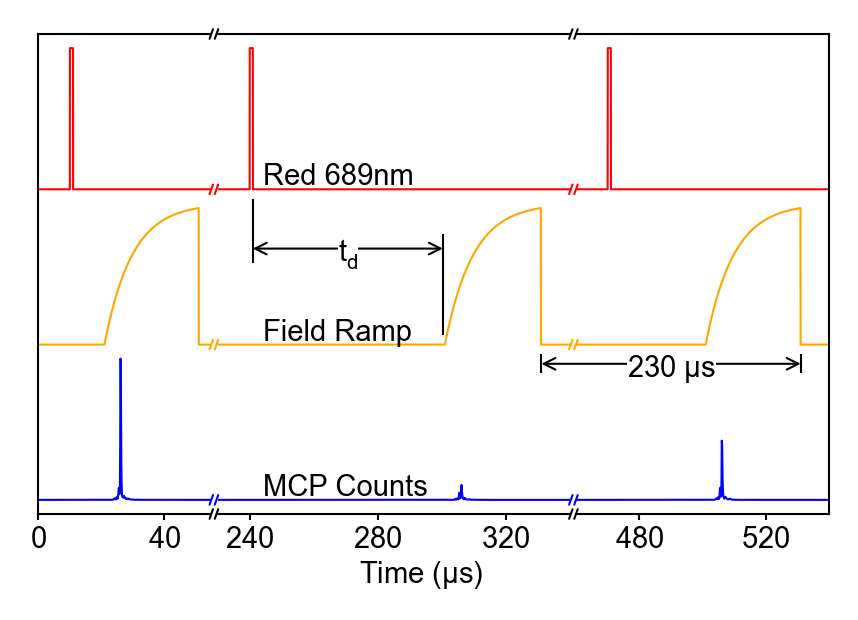

In [54]:
exposure_time = 1
red_on_time = 10
delay_times = [10,60,30]
ramp_times = [red_on_time+exposure_time+i for i in delay_times]
ramp_length = 30
normalizations = [None,np.max(dat[0]),np.max(dat[0])]
toffset = [230*i for i in range(len(dat))]
red = timingArray(time,red_on_time,red_on_time+exposure_time)
field = [field_ramp(time,
                    ramp_times[i],
                    ramp_times[i]+ramp_length,
                    exponential_ramp,fargs=[8.77])
         for i in range(len(dat))]
    
mcp = [plot_data(time,
                 ramp_times[i],dat[i][5:,:],
                 normalize=normalizations[i],
                invert = False)
       for i in range(len(dat))]

plt.figure(figsize=(3.4,2))
gs = GridSpec(1,248)
gs.update(wspace=100)
ax = [plt.subplot(gs[0,0:55]),
      plt.subplot(gs[0,56:167]),
        plt.subplot(gs[0,168:])]

#ax = [plt.subplot2grid((1,250),(0,0),colspan = 56),
#     plt.subplot2grid((1,250),(0,56),colspan = 108),
#     plt.subplot2grid((1,250),(0,164),colspan = 86)]

for i in range(len(dat)):
    plotTimingDiagram(time+toffset[i],[red,field[i],mcp[i]],
                      colors=['r','orange','blue'],
                      names=['689nm Red','Field Ramp','MCP Signal'],
                      axes=ax[i])


d=0.01
for a in ax:
    a.xaxis.set_ticks_position('bottom')
    a.tick_params(axis='x',labelsize='10')
    ax_kwargs = dict(transform=a.transAxes, clip_on=False, lw=0.5,color='k')
    line_kwargs = dict(transform=a.transAxes, clip_on=False,lw=0.5)
    if a == ax[0]:
        a.plot((1-d,1+d),(-d,d), **ax_kwargs)
        a.plot((1-d,1+d),(1-d,1+d),**ax_kwargs)
        a.plot((1.03-d,1.03+d),(1-d,1+d),**ax_kwargs)
        a.plot((1.03-d,1.03+d),(-d,d),**ax_kwargs)
        a.plot((3.08-d,3.08+d),(1-d,1+d),**ax_kwargs)
        a.plot((3.11-d,3.11+d),(1-d,1+d),**ax_kwargs)
        a.plot((3.08-d,3.08+d),(-d,d),**ax_kwargs)
        a.plot((3.11-d,3.11+d),(-d,d),**ax_kwargs)
        
        redx,redy = a.transLimits.transform([a.get_xlim()[1],0])
        yellx,yelly = a.transLimits.transform([a.get_xlim()[1],-.11])
        bx,by = a.transLimits.transform([a.get_xlim()[1],-.22])
        print(redy)
        a.plot((redx-d,redx+d),(redy-d, redy+d), color='r', **line_kwargs)
        a.plot((redx+0.03-d,redx+0.03+d),(redy-d, redy+d), color='r', **line_kwargs)
        a.plot((redx-d,redx+d),(yelly-d, yelly+d), color='orange', **line_kwargs)
        a.plot((redx+0.03-d,redx+0.03+d),(yelly-d, yelly+d), color='orange', **line_kwargs)
        a.plot((redx-d,redx+d),(by-d, by+d), color='b', **line_kwargs)
        a.plot((redx+0.03-d,redx+0.03+d),(by-d, by+d), color='b', **line_kwargs)
        redx = 3.08
        a.plot((redx+-d,redx+d),(redy-d, redy+d), color='r', **line_kwargs)
        a.plot((redx+0.03-d,redx+0.03+d),(redy-d, redy+d), color='r', **line_kwargs)
        a.plot((redx-d,redx+d),(yelly-d, yelly+d), color='orange', **line_kwargs)
        a.plot((redx+0.03-d,redx+0.03+d),(yelly-d, yelly+d), color='orange', **line_kwargs)
        a.plot((redx-d,redx+d),(by-d, by+d), color='b', **line_kwargs)
        a.plot((redx+0.03-d,redx+0.03+d),(by-d, by+d), color='b', **line_kwargs)

#### Set axis limits ####
ax[0].set_xlim(0,55)
ax[1].set_xlim(230,340)
ax[2].set_xlim(460,540)

#### Remove axis spines ####
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)        

#### Set Axis Ticks ####
ax[0].xaxis.set_ticks(np.arange(0,60,40))
ax[1].xaxis.set_ticks(np.arange(240,340,40))
ax[2].xaxis.set_ticks(np.arange(480,560,40))

for a in ax:
    a.tick_params(labelsize=7)

#### Remove Axis Labels ###
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')

#### Label lines ####
label_pad = 0.01
label_x = 1.3
ax[0].annotate('Red 689nm', xy=(0,0), xytext=(label_x, redy+label_pad), xycoords='axes fraction', fontsize=7)
ax[0].annotate('Field Ramp',xy=(0,0), xytext=(label_x, yelly+label_pad), xycoords='axes fraction',fontsize=7)
ax[0].annotate('MCP Counts', xy=(0,0), xytext=(label_x, by+label_pad), xycoords='axes fraction',fontsize=7)


#### Dimensional annotations ####
 
ramp_xi = 2.91
ramp_xf = 4.41

td_xi = 1.24
td_xf = 2.34
td_y = yelly + 0.2

dim_pad = .04

myAnnotate(ax[0], '230 $\mu$s', ramp_xi, yelly-dim_pad, ramp_xf, yelly-dim_pad, placement = 'inside', 
           coords = 'axes fraction',capsize=0.02, width=0.5)
myAnnotate(ax[0], '$t_d$', td_xi, td_y, td_xf, td_y, placement = 'inside', coords = 'axes fraction', capsize = 0,
          width = 0.5)

td_capsize = 0.03
capkwargs = dict(color='k',lw=0.5,solid_capstyle='butt',transform=ax[0].transAxes, clip_on = False)
ax[0].plot((td_xi,td_xi),(td_y-td_capsize,redy-0.02), **capkwargs)
ax[0].plot((td_xf,td_xf),(td_y+td_capsize,yelly+0.02), **capkwargs)

# force left axis to be on top for breaks
ax[0].set_zorder(1000)

#put xlabel for the whole figure at the bottom
plt.figtext(0.5,0,'Time ($\mu$s)',ha='center', va='center', fontsize='7')

plt.savefig('timing_with_ramps_good_alignment.pdf')

In [ ]:
exposure_time = 2
hold_time = 15

red = timingArray(time,181.5,181.5+exposure_time)
field = field_ramp(time,200,230,exponential_ramp,fargs=[7.7])

plotTimingDiagram(time,[odt,uv,red,field],colors=['blue','purple','r','orange'],\
                  names=['1064nm ODT','320nm UV','689nm Red','Field Ramp'],\
                 filename = 'Timing_blink_odt.svg')

In [ ]:
exposure_time = 2
hold_time = 15

odt = timingArray(time,0,230)
uv = timingArray(time,0,181.5+exposure_time)
red = timingArray(time,181.5,181.5+exposure_time)
field = timingArray(time,200,230)
plotTimingDiagram(time,[odt,uv,red,field],colors=['blue','purple','r','orange'],\
                  names=['1064nm ODT','320nm UV','689nm Red','Field Ramp'],\
                 filename = 'Timing_hold_odt.svg')